# UPS Deploy - Costs Optimization with Gurobi

Deploying a UPS could be an expensive task considering how heavy and big its components are. Battery cabinets could weigh tons and PDUs (Power Distribution Units) are also critical and costly. Space constraints are also pitfalls we can find often when there are other pieces of equipment in the same room. Then, sometimes PDUs o battery cabinets must be installed far away from the UPS, involving crazy long cables, which causes to deal with considerable costs and voltage drops. In this example, we have a typical case where the UPS has been installed, but there are just eight available spots for battery cabinets and PDUs.

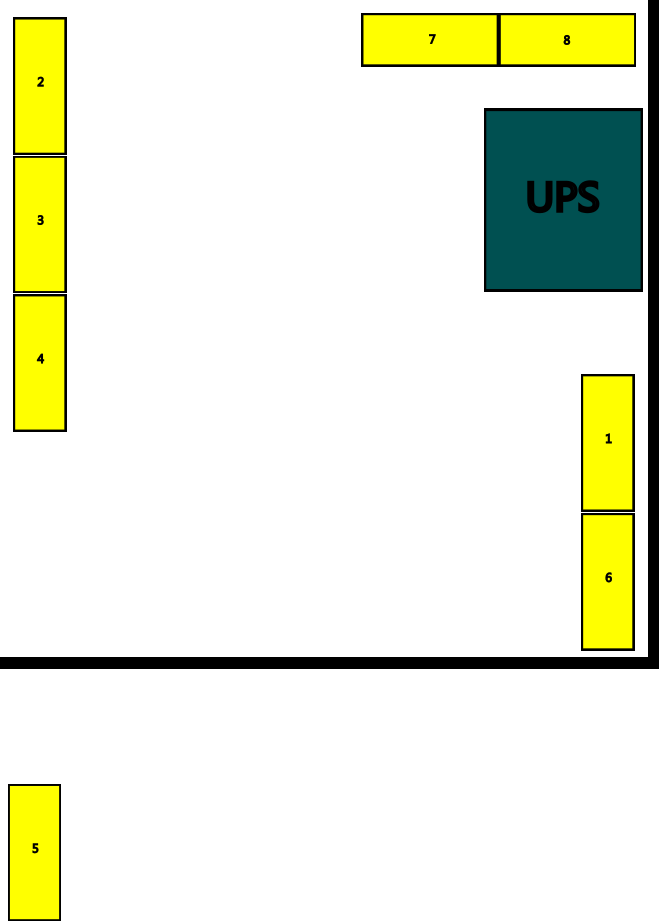

For each spot, the installation costs have been calculated. They rely on the fact that, for instance, spot 4 is already free to use for any type of cabinet (Battery or PDU). On the other hand, spots 2 and 3 have other equipment to be retired, which elevates their costs. Spot 5 is also easy for installing cabinets, but it is outside the room and needs long cables to connect what it will have. Enumerating all the details about the cost of installing something at each spot can be a never-ending story. The following table summarizes the costs and the length of the cables needed for each spot.


## Cable lengths and Deploying costs to each spot 


| Spot | Length [m] | Cost for Battery [\$] | Cost for PDU [\$] | MaxPDURate [kVA] |
| --- | --- | --- | --- | --- |
| 1 | 6 | 1000 | 500 | 30 |
| 2 | 10 | 700 | 350 | 40 |
| 3 | 12 | 800 | 550 | 80 |
| 4 | 15 | 400 | 100 | 60 |
| 5 | 20 | 650 | 250 | 20 |
| 6 | 6 | 750 | 400 | 50 |
| 7 | 8 | 950 | 950 | 20 |
| 8 | 8 | 950 | 950 | 20 |


Due to further situations found when defining the cable routing and sizing, which could be physical or even of availability or budgetary, other limitations showed up. It has not been always feasible to deploy thick cables between the UPS and each PDU. This limits the power that could flow. This constraint has been found concerning just for PDU and not for Batteries. The last column in the prior table shows the maximum rate in kVA that could possibly flow to each spot.

Additionally, there were other issues to pay attention to:
 - Spots 7 and 8 are not suitable for battery cabinets due to constraints in the floor construction.
 - At least, four PDUs must be deployed.
 - Just two battery banks will be installed
 - The must be enough number of PDUs to fully load the Ups (240kVA)

Finally, the costs of each meter of cable are:

## Cable cost per unit length

| Batt | PDU |
| --- | --- | 
| \begin{equation}{\$}{1.15}\end{equation} | \begin{equation}{\$}{0.75}\end{equation} |


An optimization problem must be deployed next to find the least costly installation as possible.

## Model Formulation

### Indices

$S(I)$: List that represent every available spot.

### Parameters

$L_{i} \in \mathbb{R}$: Lengths of cables from the UPS to each spot.

$cb_{i} \in \mathbb{R}^+ $: Cost of deploying a battery cabinet at each spot.

$cp_{i} \in \mathbb{R}^+ $: Cost of deploying a PDU at each spot.

$P_{i} \in \mathbb{R}^+$: Maximal Power that can be delivered to each spot to feed PDUs.

$CCB \in \mathbb{R}^+$: Cost of battery cables per unit length.

$CCP \in \mathbb{R}^+$: Cost of PDU cables per unit length.



In [157]:
CableCost = {'Batts': 1.15, 'PDU': 0.75}
total_load = 240

In [158]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB

In [159]:
# Parameters

spots, L, Battcost, PDUcost, PDUMaxRate = gp.multidict({
    (0): [6, 1000, 500, 30],
    (1): [10, 700, 350, 40],
    (2): [12, 800, 550, 80],
    (3): [15, 400, 100, 60],
    (4): [20, 650, 250, 20],
    (5): [6, 750, 400, 50],
    (6): [8, 0, 950, 20],
    (7): [8, 0, 950, 20]
})


### Decision Variables

$ForBatts_{i} \in \{0, 1 \}$: This variable is equal to 1 if we install a battery cabinet at the spot \$i$ and 0 otherwise.

$ForPDU_{i} \in \{0, 1 \}$: This variable is equal to 1 if we install a PDU at the spot \$i$ and 0 otherwise.

In [160]:
# Model formulation

m = gp.Model("DeployUPS")

# Add variables
ForBatts = m.addVars(spots[0:6], vtype=GRB.BINARY, name = "ForBatts")
ForPDU = m.addVars(spots, vtype=GRB.BINARY, name = "ForPDU")

Notice that for battery indexes just spots from 0 through 5 where defined for the variable $ForBatts_{i}$ 

## Constraints 1 through 6: There cannot be a battery cabinet where a PDU will be installed (and vice-versa)

\begin{equation}
ForBatts_{i} + ForPDU_{i} <= 1 \quad \forall i \in I(0:5)
\tag{1-6}
\end{equation}

In [161]:
# Add constraints
# In every spot there must be a Battery cabinet or a PDU. They cannot have two
m.addConstrs((ForBatts[s] + ForPDU[s] <= 1 for s in spots[0:6]), name = "OrBattOrPDU")

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>}

## Constraint 7: There must be just two battery banks



\begin{equation}
\sum_{i \in I} ForBatts_{i} = 2 \quad \forall i \in I(0:5)
\tag{7}
\end{equation}

In [162]:
m.addConstr(ForBatts.sum('*') == 2, name = "Just2Batts")

<gurobi.Constr *Awaiting Model Update*>

## Constraint 8: There must be at least four PDUs



\begin{equation}
\sum_{i \in I} ForPDU_{i} <= 4 \quad \forall i \in I
\tag{8}
\end{equation}

In [163]:
m.addConstr(ForPDU.sum('*') >= 4, name = "AtLeast4PDUs")

<gurobi.Constr *Awaiting Model Update*>

## Constraint 9: All 240kVA must be fullfilled

\begin{equation}
\sum_{i \in I} P_{i}*ForPDU_{i} >= 240kVA \quad \forall i \in I
\tag{9}
\end{equation}

In [164]:
m.addConstr(ForPDU.prod(PDUMaxRate) >= total_load, name = "ProvideAllLoad")

<gurobi.Constr *Awaiting Model Update*>

## Objective Function: 

\begin{equation}
\text{Min} \sum_{i \in I} cp_{i} \cdot ForPDU_{i} + cb_{i} \cdot ForBatts_{i} + CCP \cdot L_{i} \cdot ForPDU_{i} + CCB \cdot L_{i} \cdot ForBatts_{i}  \quad \forall i \in I
\tag{10}
\end{equation}


In [165]:
obj = ForPDU.prod(PDUcost) + ForBatts.prod(Battcost) + CableCost["PDU"]*ForPDU.prod(L) + CableCost["Batts"]*ForBatts.prod(L)

m.setObjective(obj, GRB.MINIMIZE)


In [166]:
m.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-7500U CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 9 rows, 14 columns and 34 nonzeros
Model fingerprint: 0xed144796
Variable types: 0 continuous, 14 integer (14 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [1e+02, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 4827.7500000
Presolve removed 5 rows and 6 columns
Presolve time: 0.00s
Presolved: 4 rows, 8 columns, 15 nonzeros
Variable types: 0 continuous, 8 integer (7 binary)

Root relaxation: objective 3.590150e+03, 6 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3590.15000    0    1 4827.7

The optimal results yield a cost of USD 3939.75 and comprise deploying battery banks in spots 2 and 5 whereas five PDUs must be installed in spots 1, 3, 4, 6, and 8.

In [167]:
ForBatts

{0: <gurobi.Var ForBatts[0] (value -0.0)>,
 1: <gurobi.Var ForBatts[1] (value 1.0)>,
 2: <gurobi.Var ForBatts[2] (value 0.0)>,
 3: <gurobi.Var ForBatts[3] (value 0.0)>,
 4: <gurobi.Var ForBatts[4] (value 1.0)>,
 5: <gurobi.Var ForBatts[5] (value -0.0)>}

In [168]:
ForPDU

{0: <gurobi.Var ForPDU[0] (value 1.0)>,
 1: <gurobi.Var ForPDU[1] (value 0.0)>,
 2: <gurobi.Var ForPDU[2] (value 1.0)>,
 3: <gurobi.Var ForPDU[3] (value 1.0)>,
 4: <gurobi.Var ForPDU[4] (value -0.0)>,
 5: <gurobi.Var ForPDU[5] (value 1.0)>,
 6: <gurobi.Var ForPDU[6] (value 0.0)>,
 7: <gurobi.Var ForPDU[7] (value 1.0)>}